In [1]:
# Standard operational package imports
import numpy as np
import pandas as pd

# Important imports for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from scipy.interpolate import interp1d

%pip install mlxtend
from mlxtend.evaluate import bias_variance_decomp
import sklearn.metrics as metrics

# Visualization package imports
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

Note: you may need to restart the kernel to use updated packages.


<h2>Section 1: Technical Analysis & Code</h2>

<h3>Dataset loading and basic exploration</h3>

Combined Cycle Power Plant Data Set<br>

Data Set Information:<br>

This UCI dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.<br>



The power plant being at full load means that there shouldn't be any confounding due to variations in the independent variables.




Attribute Information:<br>

Features consist of hourly average ambient variables<br>

Temperature (T) in the range 1.81°C and 37.11°C,<br>
Ambient Pressure (AP) in the range 992.89-1033.30 milibar,<br>
Relative Humidity (RH) in the range 25.56% to 100.16%<br>
Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg<br>
Net hourly electrical energy output (EP) 420.26-495.76 MW<br>

In [2]:
ppep_df = pd.read_csv('Power Plant Data.csv')

ppep_df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


The dataset is sorted by net hourly electrical output (PE) to perform a quick visual analysis of correlation with other variables.

In [3]:
ppep_df_sorted = ppep_df.sort_values('AT')
ppep_df_sorted = ppep_df.sort_values('AP')
ppep_df_sorted = ppep_df.sort_values('V')
ppep_df_sorted = ppep_df.sort_values('RH')
ppep_df_sorted = ppep_df.sort_values('PE').reset_index(drop=True)

ppep_df_sorted

,AT,V,AP,RH,PE
0,24.27,63.87,1018.88,53.96,420.26
1,23.00,66.05,1020.61,80.29,421.57
2,32.56,68.14,1004.02,35.04,425.11
3,31.74,72.58,1007.26,59.58,425.12
4,29.67,71.98,1005.16,67.75,425.14
...,...,...,...,...,...
9563,6.17,40.07,1013.70,58.99,495.21
9564,5.25,40.07,1019.48,67.70,495.23
9565,5.41,40.07,1019.16,64.77,495.24
9566,5.15,40.07,1012.27,63.31,495.35


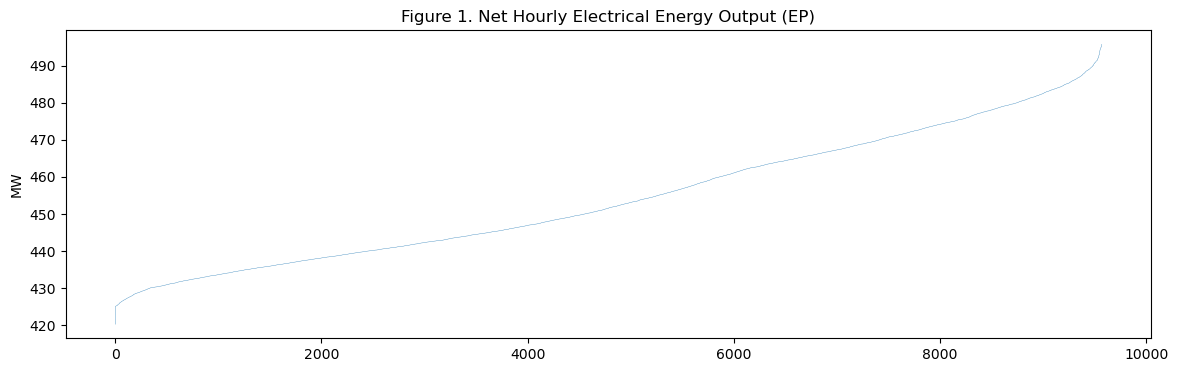

In [4]:
fig = plt.figure(figsize=(14,4))

plt.title('Figure 1. Net Hourly Electrical Energy Output (EP)')

plt.ylabel('MW')

plt.plot(ppep_df_sorted['PE'], linewidth=0.25)

plt.show()

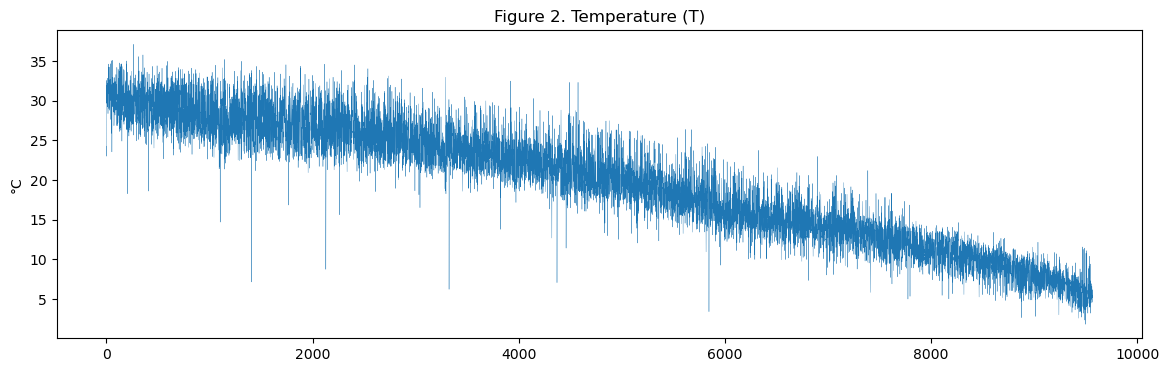

In [5]:
fig = plt.figure(figsize=(14,4))

plt.title('Figure 2. Temperature (T)')

plt.ylabel('°C')

plt.plot(ppep_df_sorted['AT'], linewidth=0.25)

plt.show()

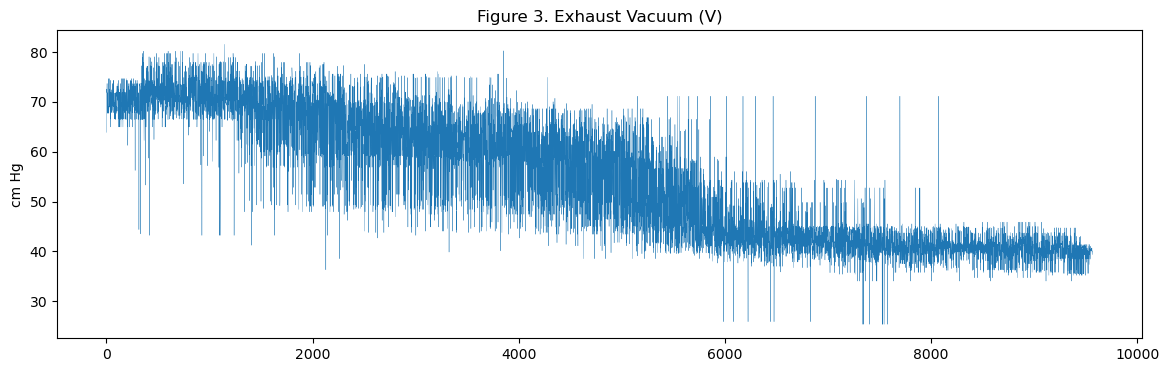

In [6]:
fig = plt.figure(figsize=(14,4))

plt.title('Figure 3. Exhaust Vacuum (V)')

plt.ylabel('cm Hg')

plt.plot(ppep_df_sorted['V'], linewidth=0.25)

plt.show()

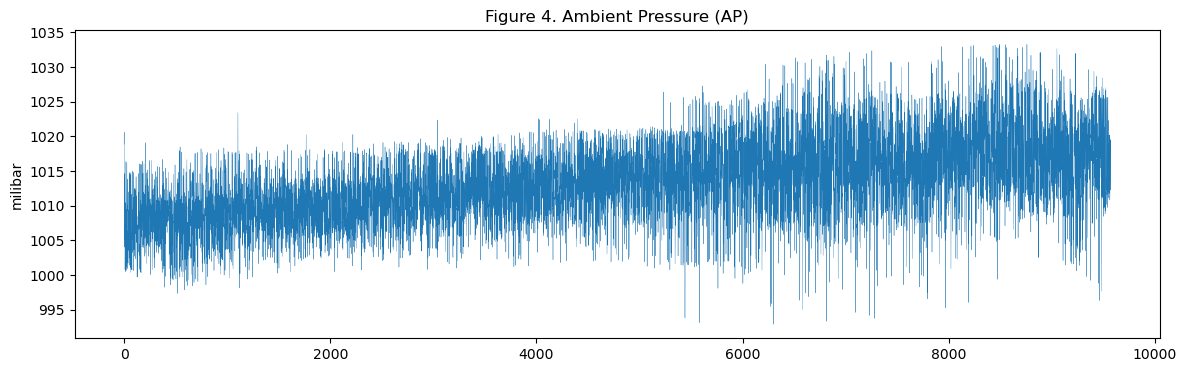

In [7]:
fig = plt.figure(figsize=(14,4))

plt.title('Figure 4. Ambient Pressure (AP)')

plt.ylabel('milibar')

plt.plot(ppep_df_sorted['AP'], linewidth=0.25)

plt.show()

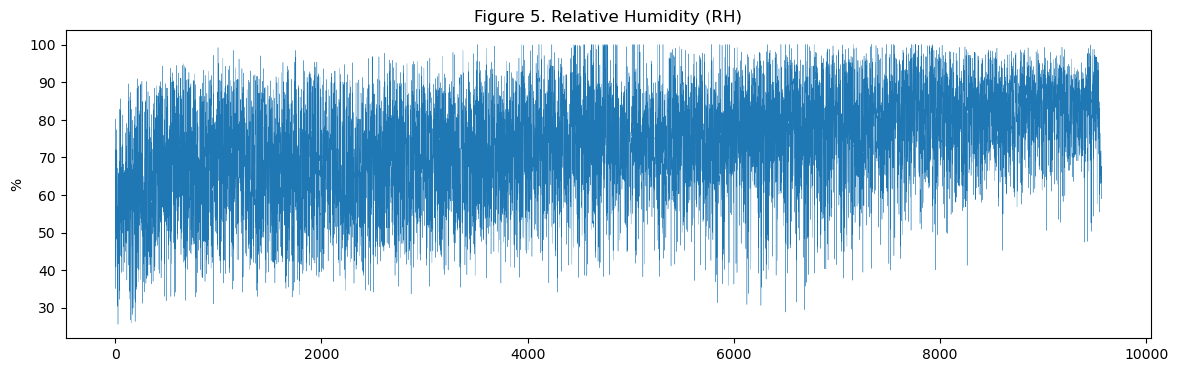

In [8]:
fig = plt.figure(figsize=(14,4))

plt.title('Figure 5. Relative Humidity (RH)')

plt.ylabel('%')

plt.plot(ppep_df_sorted['RH'], linewidth=0.25)

plt.show()

A quick visual analysis of the dataset shows an inversely proportional relationship between {exhaust vacuum, temperature} and electrical output. A proportional relationship is shown between {ambient pressure, relative humidity} and electrical output. This should mean that it is possible to accurately predict electrical output based on these variables.

In [9]:
ppep_df_sorted_subset = ppep_df_sorted.dropna(axis=0).reset_index(drop = True)

ppep_df_sorted_subset = ppep_df_sorted_subset.astype(int)

ppep_df_sorted_subset

,AT,V,AP,RH,PE
0,24,63,1018,53,420
1,23,66,1020,80,421
2,32,68,1004,35,425
3,31,72,1007,59,425
4,29,71,1005,67,425
...,...,...,...,...,...
9563,6,40,1013,58,495
9564,5,40,1019,67,495
9565,5,40,1019,64,495
9566,5,40,1012,63,495


In [10]:
ppep_df_sorted_subset = pd.get_dummies(ppep_df_sorted_subset, drop_first = True)

ppep_df_sorted_subset

,AT,V,AP,RH,PE
0,24,63,1018,53,420
1,23,66,1020,80,421
2,32,68,1004,35,425
3,31,72,1007,59,425
4,29,71,1005,67,425
...,...,...,...,...,...
9563,6,40,1013,58,495
9564,5,40,1019,67,495
9565,5,40,1019,64,495
9566,5,40,1012,63,495


In [11]:
y = ppep_df_sorted_subset["PE"]

X = ppep_df_sorted_subset.copy()
X = X.drop("PE", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [12]:
dt_pred = {}

MAX_DEPTH = [3, 5, 10]

Testset vs. Predictions
MAX_DEPTH = 3
Accuracy: 0.0732
Precision: 0.0105
Recall: 0.0732
F1 Score: 0.0179


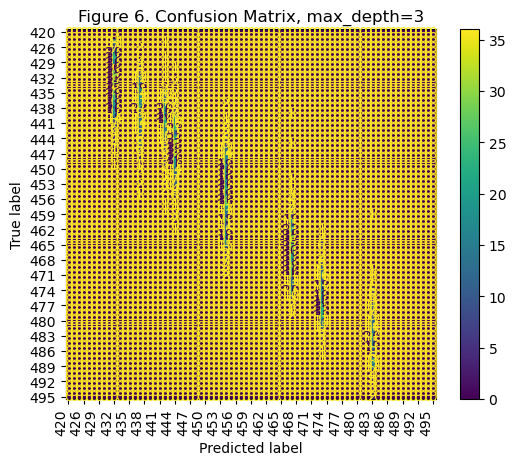

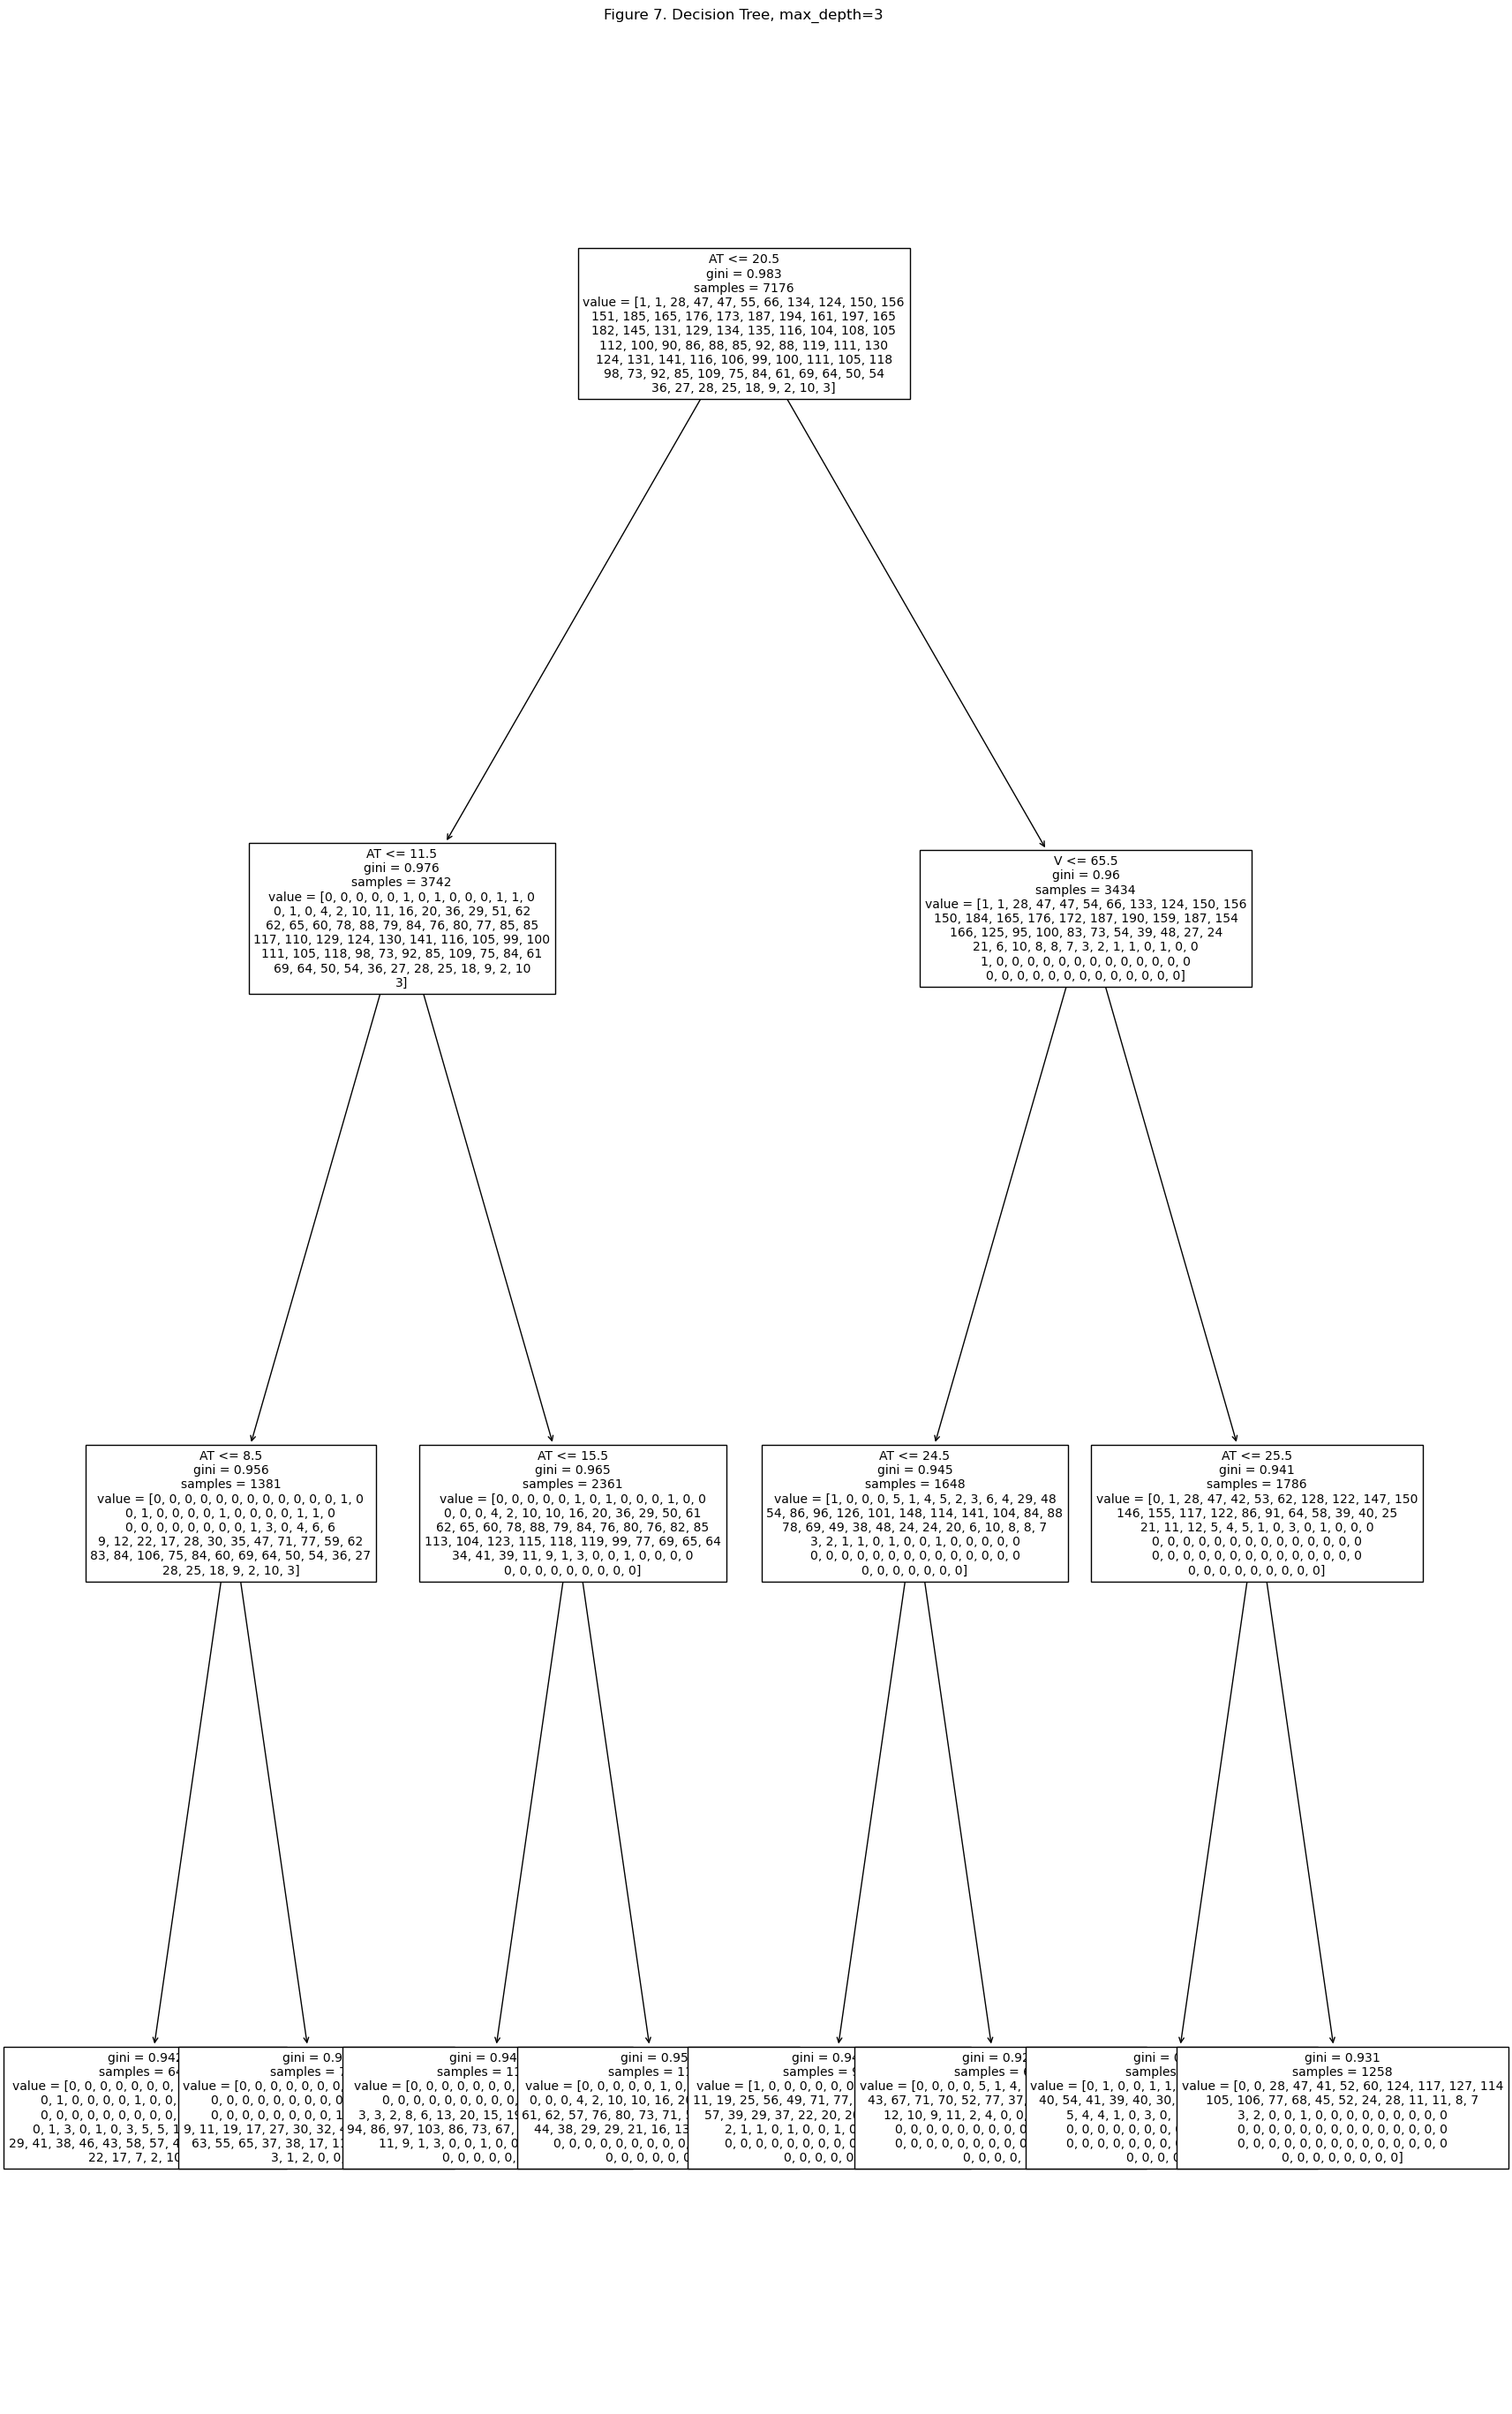

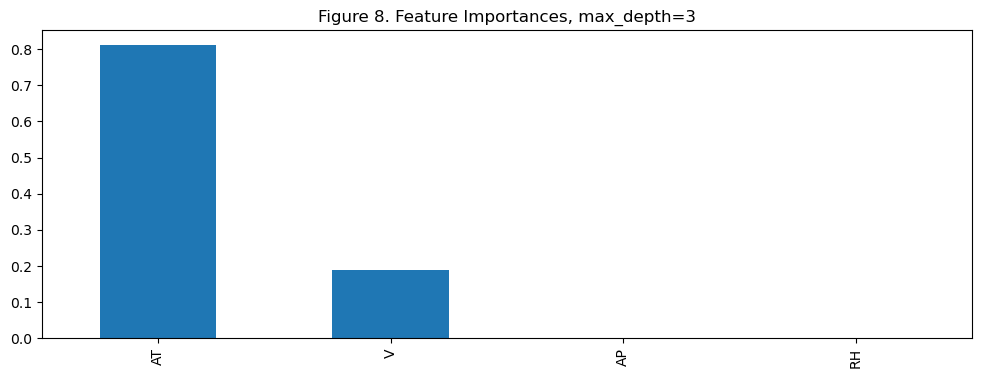

Bias-Variance
MAX_DEPTH = 3
Average expected loss: 0.9234
Average bias: 0.9268
Average variance: 0.5959
Testset vs. Predictions
MAX_DEPTH = 5
Accuracy: 0.0911
Precision: 0.0446
Recall: 0.0911
F1 Score: 0.0513


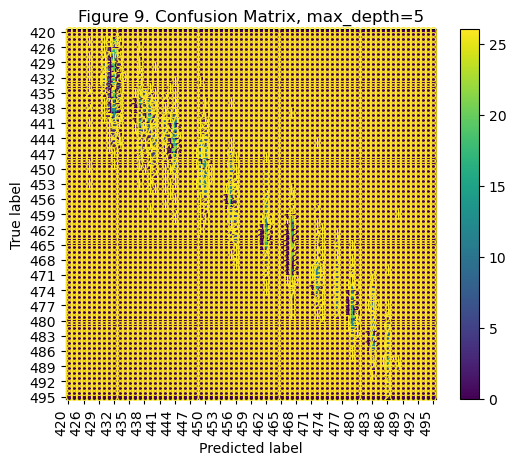

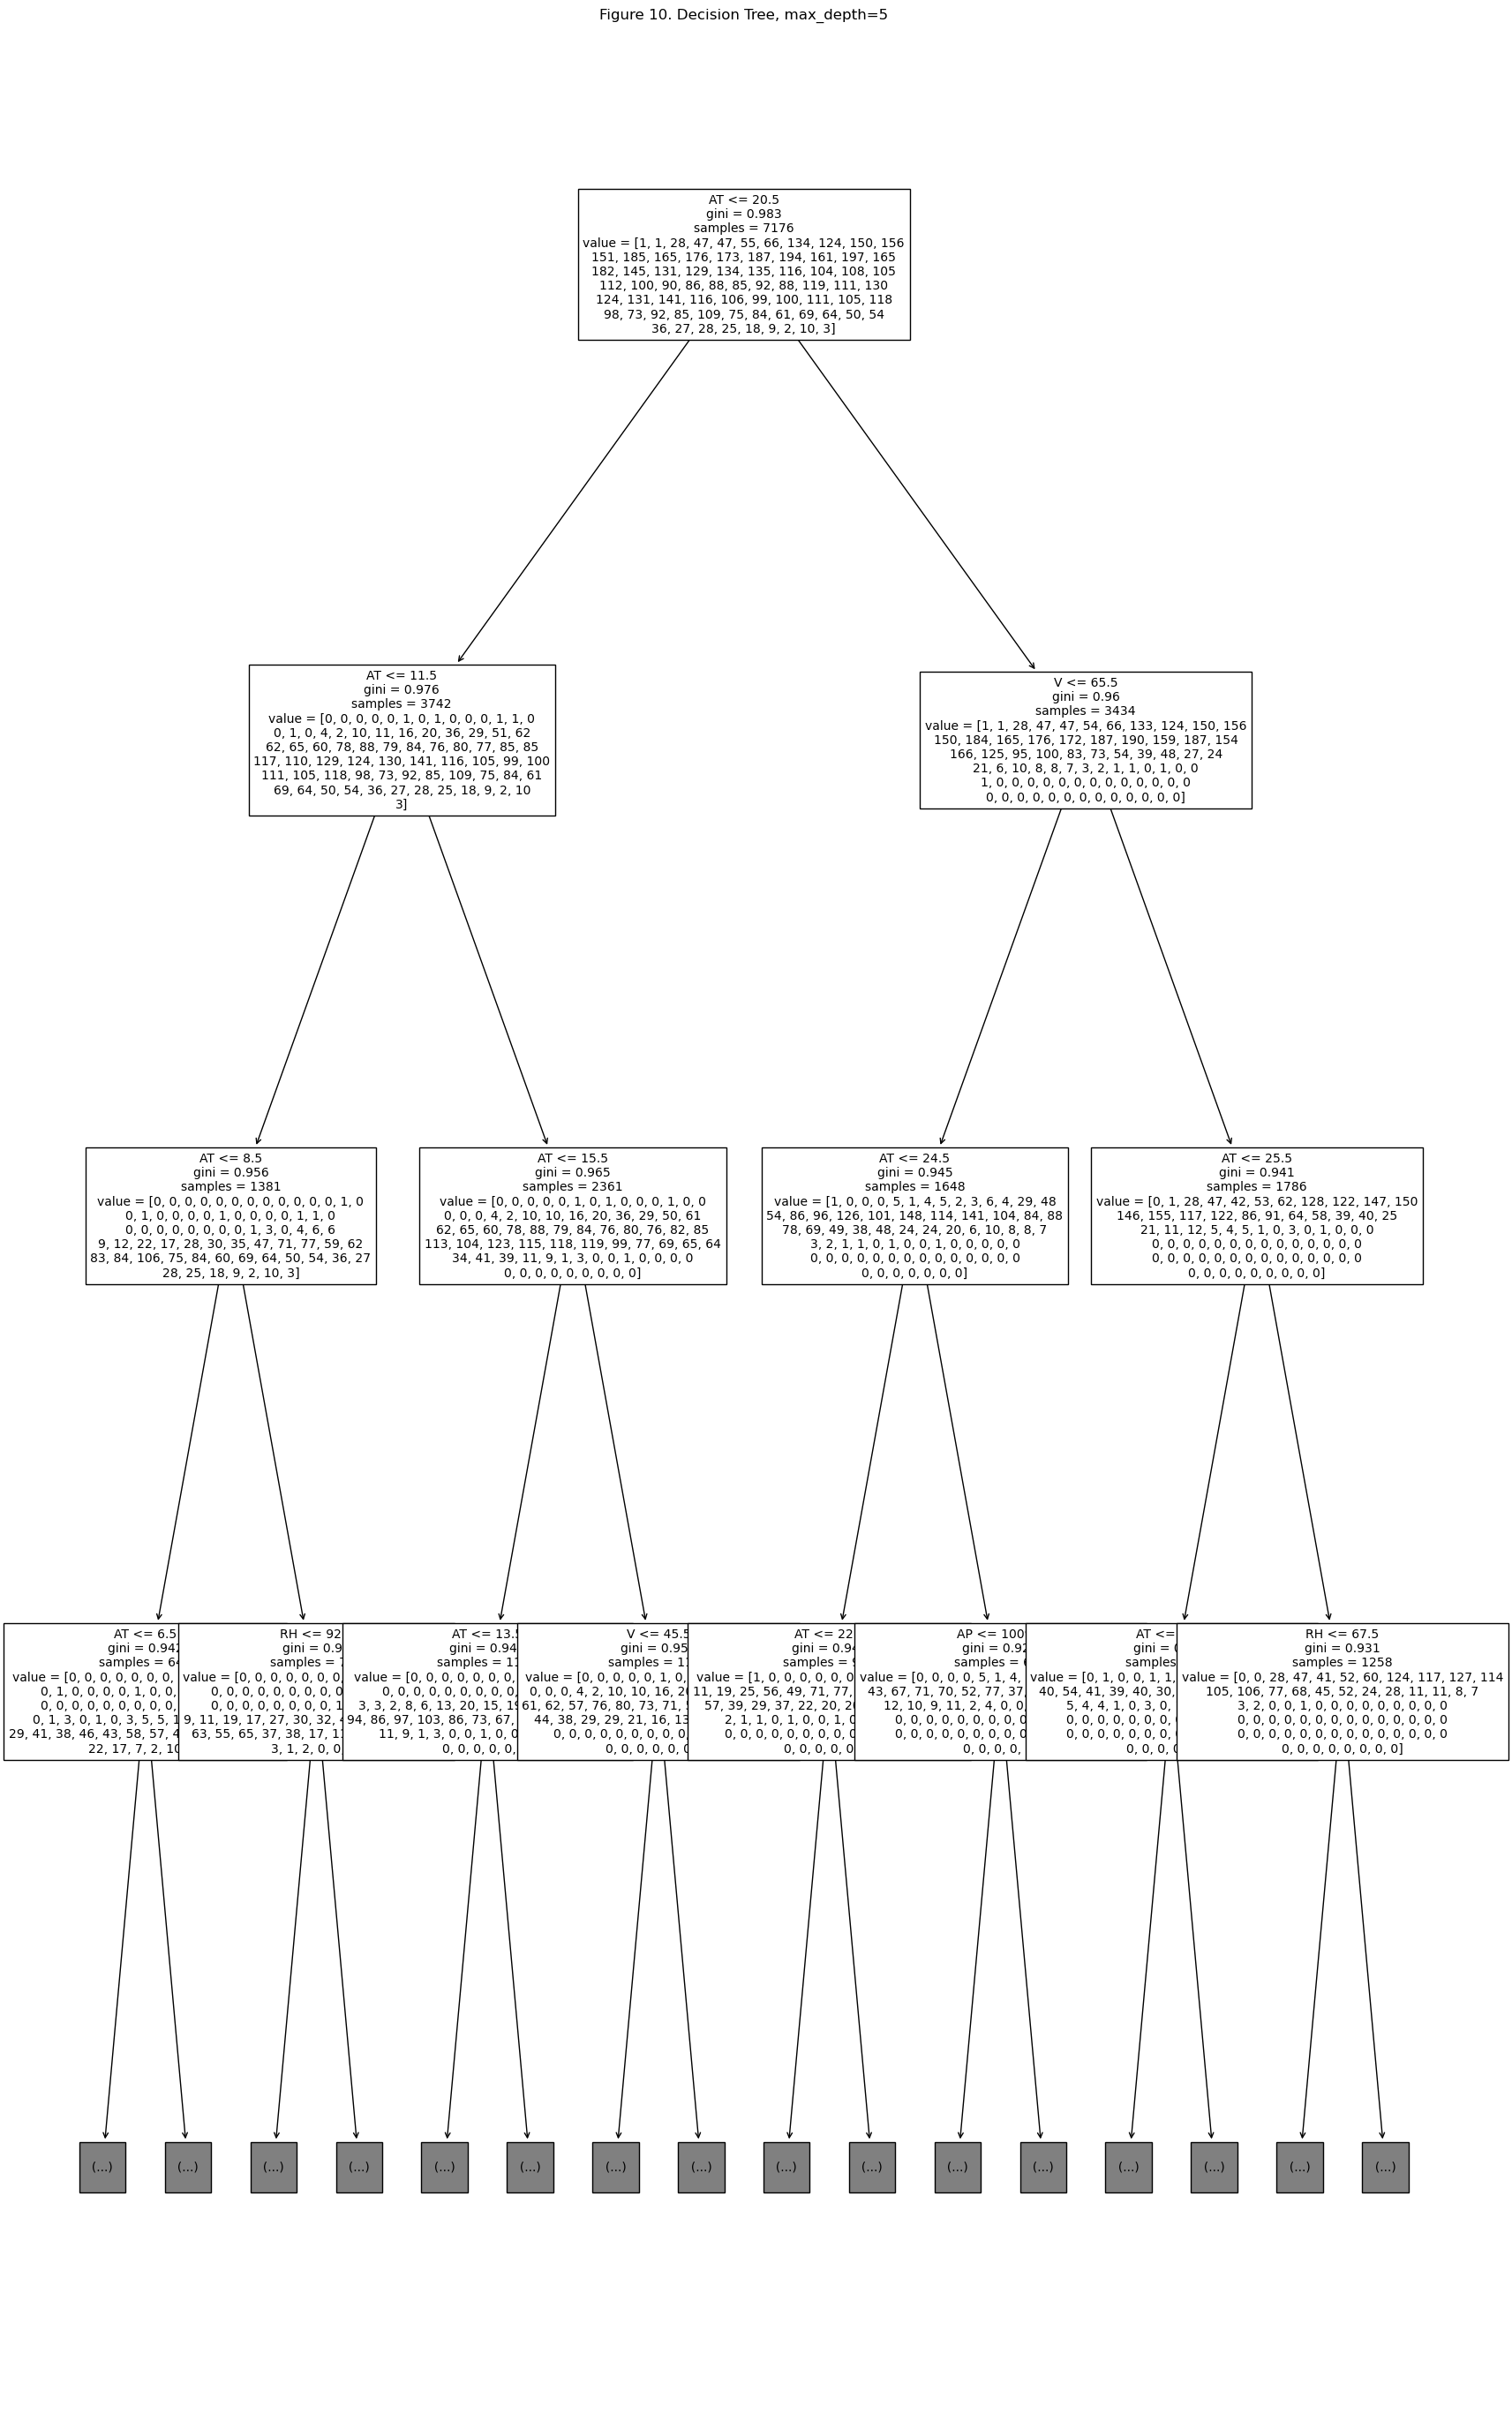

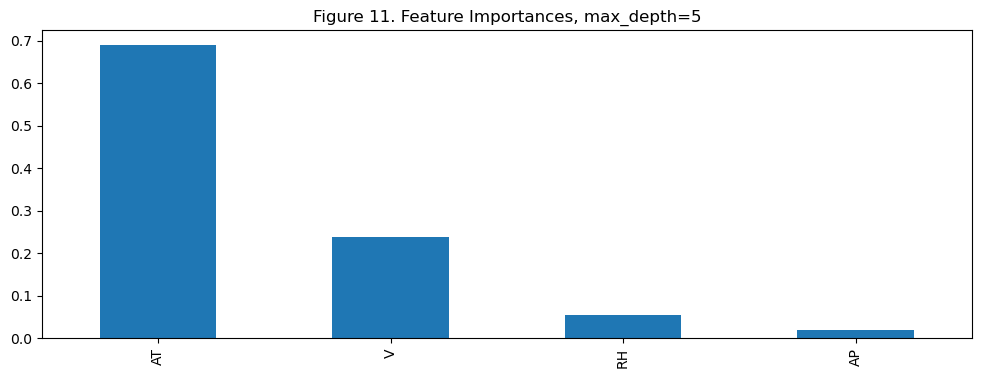

Bias-Variance
MAX_DEPTH = 5
Average expected loss: 0.9127
Average bias: 0.9072
Average variance: 0.6093
Testset vs. Predictions
MAX_DEPTH = 10
Accuracy: 0.1217
Precision: 0.1307
Recall: 0.1217
F1 Score: 0.1134


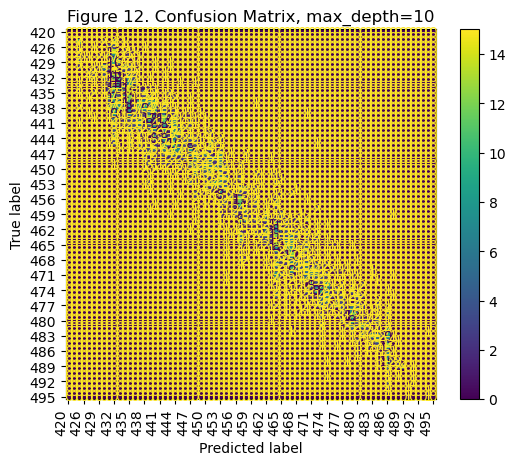

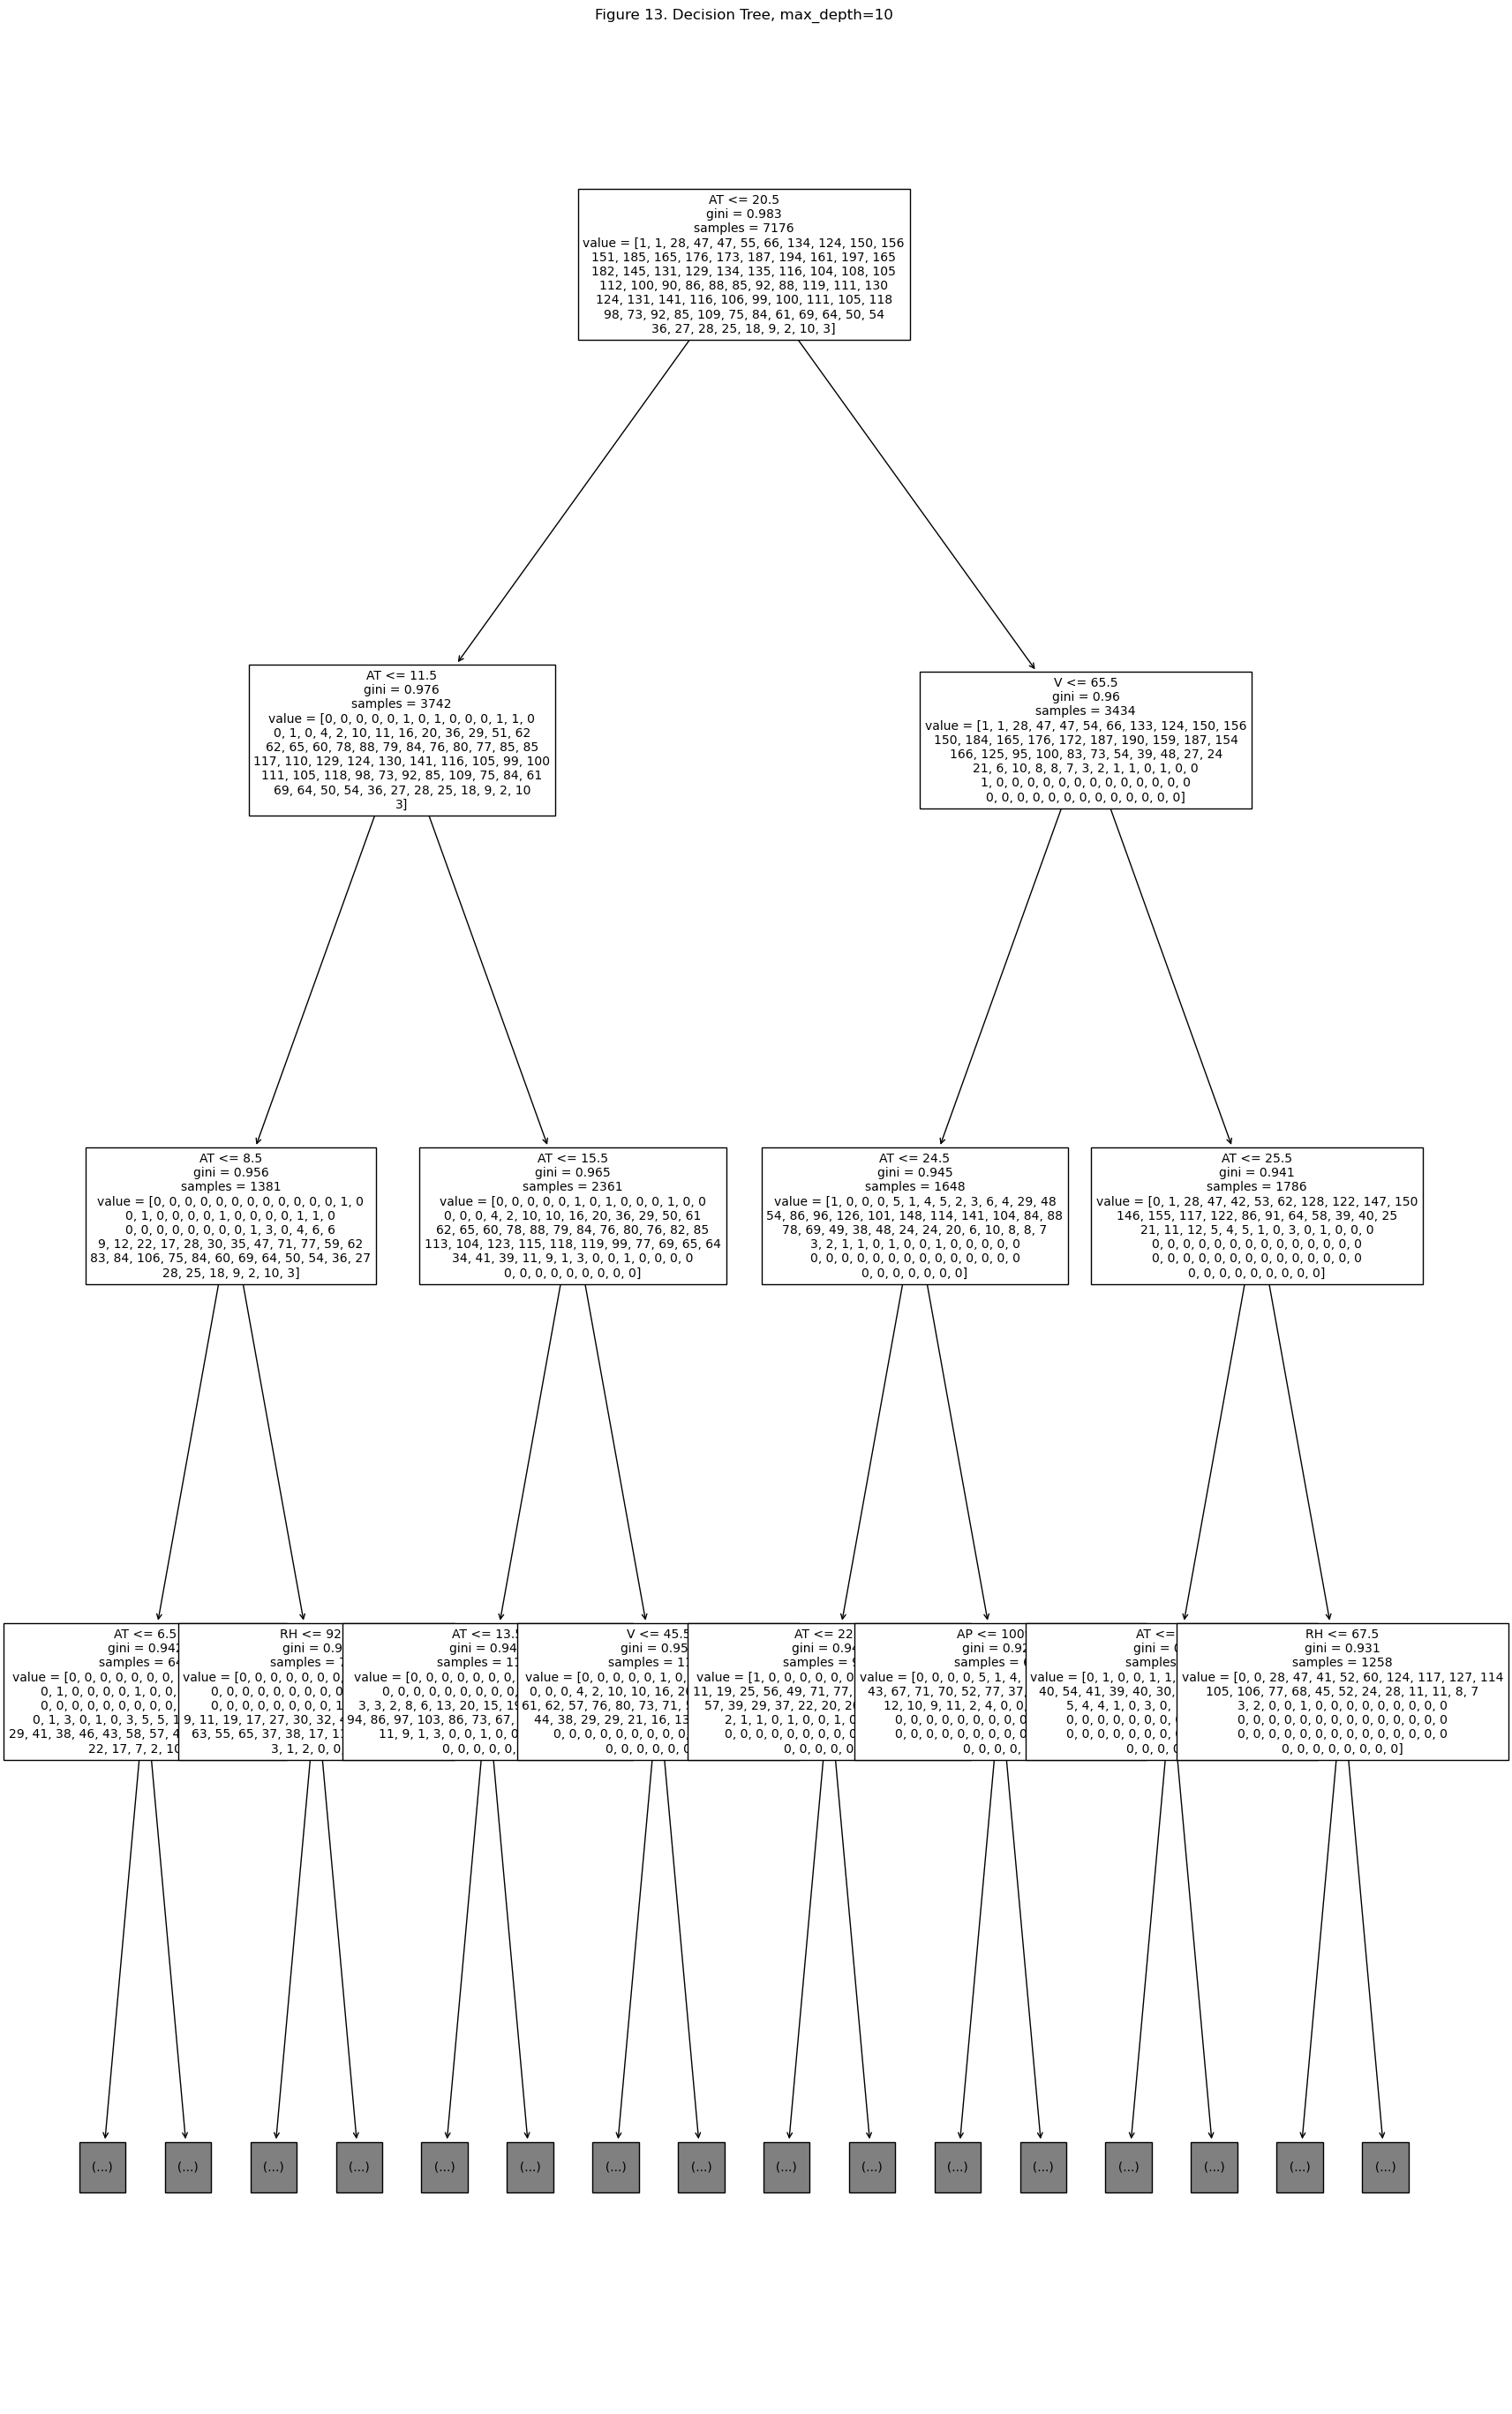

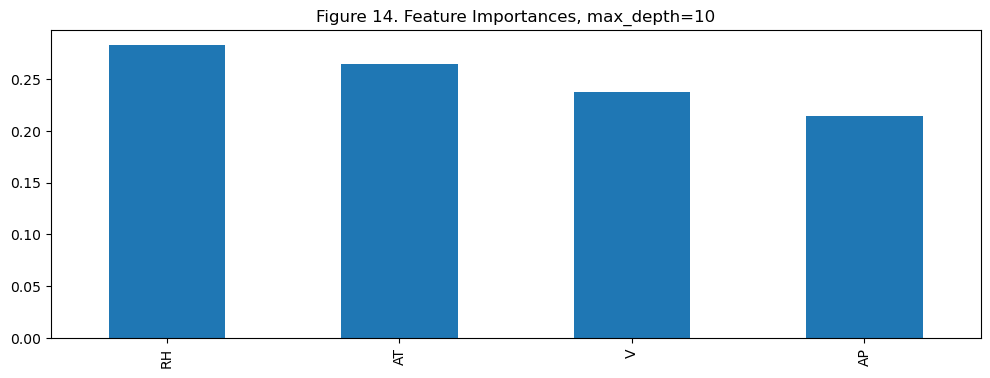

Bias-Variance
MAX_DEPTH = 10
Average expected loss: 0.8924
Average bias: 0.8691
Average variance: 0.6815


In [13]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=3)
    
decision_tree.fit(X_train, y_train)
    
dt_pred[3] = decision_tree.predict(X_test)
print(f"Testset vs. Predictions")
print(f"MAX_DEPTH = {3}")
print(f"Accuracy: {np.round(metrics.accuracy_score(y_test, dt_pred[3]),4)}")
print(f"Precision: {np.round(metrics.precision_score(y_test, dt_pred[3], average='weighted',zero_division=0),4)}")
print(f"Recall: {np.round(metrics.recall_score(y_test, dt_pred[3], average='weighted',zero_division=0),4)}")
print(f"F1 Score: {np.round(metrics.f1_score(y_test, dt_pred[3], average='weighted',zero_division=0),4)}")
    
cm = metrics.confusion_matrix(y_test, dt_pred[3], labels = decision_tree.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = decision_tree.classes_)

disp.plot()
plt.title(f"Figure 6. Confusion Matrix, max_depth=3")

tick_locations = np.arange(0, len(decision_tree.classes_), 3)  
tick_labels = [decision_tree.classes_[i] for i in tick_locations]

disp.ax_.set_xticks(tick_locations)
disp.ax_.set_xticklabels(tick_labels, rotation=90, ha='right')

disp.ax_.set_yticks(tick_locations)
disp.ax_.set_yticklabels(tick_labels)

plt.show()



plt.figure(figsize=(20,35))
plot_tree(decision_tree, max_depth=3, fontsize=10, feature_names=X.columns)
plt.title(f"Figure 7. Decision Tree, max_depth=3")
plt.show()

importances = decision_tree.feature_importances_
forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12,4))
forest_importances.plot.bar(ax=ax)
plt.title(f"Figure 8. Feature Importances, max_depth=3")
plt.show()
    

print(f"Bias-Variance")
print(f"MAX_DEPTH = {3}")
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    decision_tree, X_train.values, y_train.values, X_test.values, y_test.values, 
    num_rounds=200,  
    random_seed=1
)
    
print(f"Average expected loss: {avg_expected_loss:.4f}")
print(f"Average bias: {avg_bias:.4f}")
print(f"Average variance: {avg_var:.4f}")

decision_tree = DecisionTreeClassifier(random_state=0, max_depth=5)
    
decision_tree.fit(X_train, y_train)
    
dt_pred[5] = decision_tree.predict(X_test)
print(f"Testset vs. Predictions")
print(f"MAX_DEPTH = {5}")
print(f"Accuracy: {np.round(metrics.accuracy_score(y_test, dt_pred[5]),4)}")
print(f"Precision: {np.round(metrics.precision_score(y_test, dt_pred[5], average='weighted',zero_division=0),4)}")
print(f"Recall: {np.round(metrics.recall_score(y_test, dt_pred[5], average='weighted',zero_division=0),4)}")
print(f"F1 Score: {np.round(metrics.f1_score(y_test, dt_pred[5], average='weighted',zero_division=0),4)}")
    
cm = metrics.confusion_matrix(y_test, dt_pred[5], labels = decision_tree.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = decision_tree.classes_)

disp.plot()
plt.title(f"Figure 9. Confusion Matrix, max_depth=5")

tick_locations = np.arange(0, len(decision_tree.classes_), 3)  
tick_labels = [decision_tree.classes_[i] for i in tick_locations]

disp.ax_.set_xticks(tick_locations)
disp.ax_.set_xticklabels(tick_labels, rotation=90, ha='right')

disp.ax_.set_yticks(tick_locations)
disp.ax_.set_yticklabels(tick_labels)

plt.show()



plt.figure(figsize=(20,35))
plot_tree(decision_tree, max_depth=3, fontsize=10, feature_names=X.columns)
plt.title(f"Figure 10. Decision Tree, max_depth=5")
plt.show()

importances = decision_tree.feature_importances_
forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12,4))
forest_importances.plot.bar(ax=ax)
plt.title(f"Figure 11. Feature Importances, max_depth=5")
plt.show()
    

print(f"Bias-Variance")
print(f"MAX_DEPTH = {5}")
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    decision_tree, X_train.values, y_train.values, X_test.values, y_test.values, 
    num_rounds=200,  
    random_seed=1
)
    
print(f"Average expected loss: {avg_expected_loss:.4f}")
print(f"Average bias: {avg_bias:.4f}")
print(f"Average variance: {avg_var:.4f}")

decision_tree = DecisionTreeClassifier(random_state=0, max_depth=10)
    
decision_tree.fit(X_train, y_train)
    
dt_pred[10] = decision_tree.predict(X_test)
print(f"Testset vs. Predictions")
print(f"MAX_DEPTH = {10}")
print(f"Accuracy: {np.round(metrics.accuracy_score(y_test, dt_pred[10]),4)}")
print(f"Precision: {np.round(metrics.precision_score(y_test, dt_pred[10], average='weighted',zero_division=0),4)}")
print(f"Recall: {np.round(metrics.recall_score(y_test, dt_pred[10], average='weighted',zero_division=0),4)}")
print(f"F1 Score: {np.round(metrics.f1_score(y_test, dt_pred[10], average='weighted',zero_division=0),4)}")
    
cm = metrics.confusion_matrix(y_test, dt_pred[10], labels = decision_tree.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = decision_tree.classes_)

disp.plot()
plt.title(f"Figure 12. Confusion Matrix, max_depth=10")

tick_locations = np.arange(0, len(decision_tree.classes_), 3)  
tick_labels = [decision_tree.classes_[i] for i in tick_locations]

disp.ax_.set_xticks(tick_locations)
disp.ax_.set_xticklabels(tick_labels, rotation=90, ha='right')

disp.ax_.set_yticks(tick_locations)
disp.ax_.set_yticklabels(tick_labels)

plt.show()



plt.figure(figsize=(20,35))
plot_tree(decision_tree, max_depth=3, fontsize=10, feature_names=X.columns)
plt.title(f"Figure 13. Decision Tree, max_depth=10")
plt.show()

importances = decision_tree.feature_importances_
forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12,4))
forest_importances.plot.bar(ax=ax)
plt.title(f"Figure 14. Feature Importances, max_depth=10")
plt.show()
    

print(f"Bias-Variance")
print(f"MAX_DEPTH = {10}")
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    decision_tree, X_train.values, y_train.values, X_test.values, y_test.values, 
    num_rounds=200,  
    random_seed=1
)
    
print(f"Average expected loss: {avg_expected_loss:.4f}")
print(f"Average bias: {avg_bias:.4f}")
print(f"Average variance: {avg_var:.4f}")

<h2>Section 2: Technical Stakeholder Report</h2>

<h3>Dataset & Prediction Goal</h3>

The dataset is composed of some standard variables used to monitor and control a typical power plant. The goal of the assignment is to predict the electrical output based on the input variables. The most proportional relationship is Temperature vs. Electrical Output (T vs. PE). Lower temperatures result in higher output power when the plant is at full power. Higher temperatures result in lower output power when the plant is at full power. The plant being at full power means that whatever the prime mover is is operating at full capacity, and so, additional electrical output while at 100% operational capacity translates into reduced cost for similar power output. As the decision tree depth is raised, the importance of the other independent variables begins to match the importance of temperature.

<h3>Methodology Summary</h3>

The train/test split of 80/20 is selected as a fairly standard train/test split. Three models are developed with MAX_DEPTH={3,5,10} per the recommemdation in the assignment.

<h3>Accuracy</h3>

The highest accuracy measured is approximately 12%. On first glance, it seems low; however, a quick and simple visualization at least shows that there is a some correlation between the y_test and predicted output.

<h3>Model Performance Comparison</h3>

In [14]:
for key, value in dt_pred.items():
    print(f"\nMAX_DEPTH={key}\nAccuracy:", "%.2f" % metrics.accuracy_score(y_test, value))


MAX_DEPTH=3
Accuracy: 0.07

MAX_DEPTH=5
Accuracy: 0.09

MAX_DEPTH=10
Accuracy: 0.12


As MAX_DEPTH is raised, the accuracy of the model is also raised. The accuracy is the model, even at MAX_DEPTH=10, is deceptively low. A visual inspection of the test dataset vs. the predictions shows a some type of correlation. A linear regression is performed on the predictions and the resultant linear function is a quick and simple match to the electrical output (PE) of the original dataset. Further exploration of the decision tree predictive model could result in more complex regressions, like a polynomial fit.

<span style="color:red">Curiously, temperature is the most important feature at max_depth=3, and that matches with the visual inspection. At max_depth=10, relative humidity becomes the most important feature. Based on the physical characteristics of a power plant, this should make sense. Relative humidity affects the evaporative cooling available to a plant heat engine, and so, it makes sense it would be an important feature.</span>

In [15]:
print(ppep_df_sorted['AT'].var())
print(ppep_df_sorted['RH'].var())

55.539357238069954
213.16784776871484


<span style="color:red">The conventional knowledge is that a high variance in an independent feature might result in overfitting. There isn't evidence of overfitting in this prediction set. The variance of Temperature vs. Relative Humidity seems to match the difference between feature importance for the max_depth=3 model and the max_depth=10 model. Given how important Relative Humidity is to evaporative cooling, it makes sense given knowledge of a power plant that it would be one of the most, if not the most, important feature(s). This leads to the belief that the models with higher depths have a higher sensitivity to minute changes in Relative Humidity.</span><br>

<span style="color:red">The temperature measurements may be dry bulb temperature measurements rather than wet bulb temperature measurements. This would lead to a difference in accuracy if the minute changes of Relative Humidity are given additional weight.</span>



In [16]:
def linear_function(m, x, b):
    return m*x+b

x = np.linspace(0, dt_pred[10].shape[0]-1, dt_pred[10].shape[0])

x.shape

(2392,)

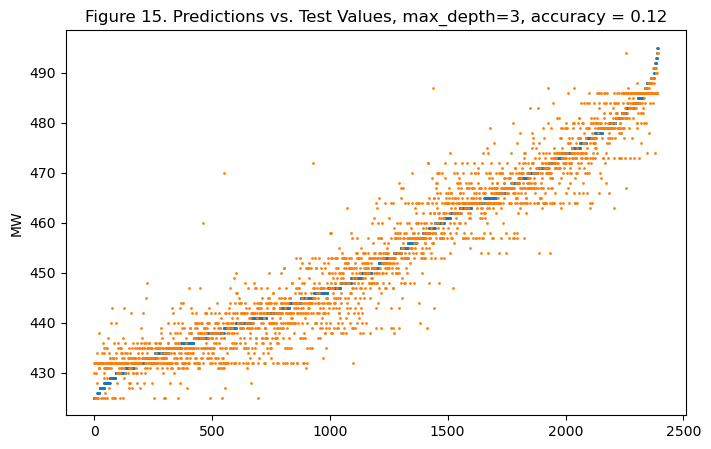

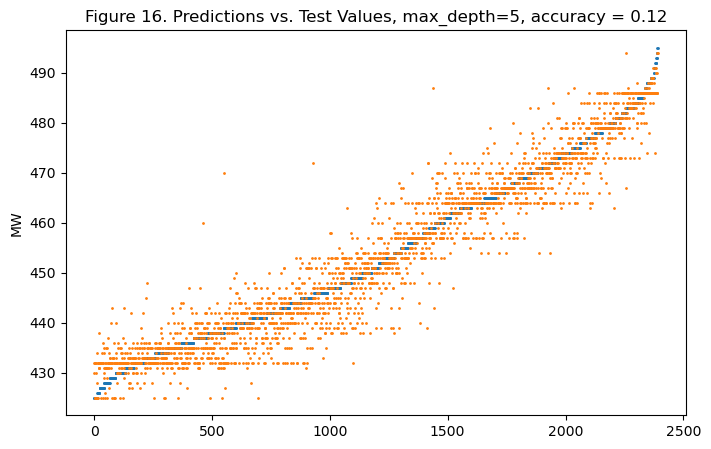

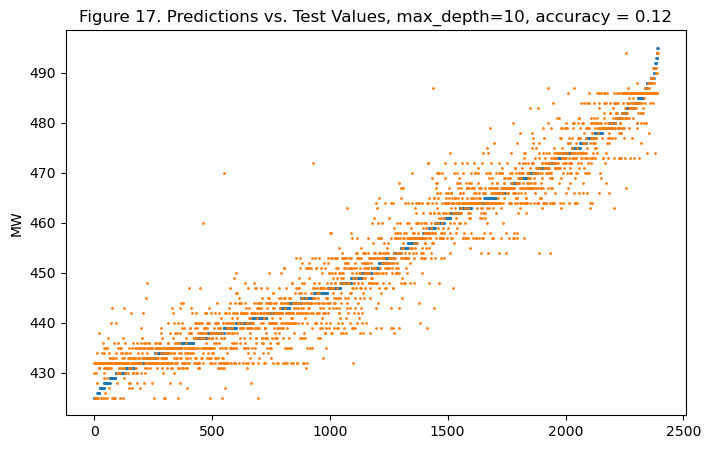

In [17]:
fig = plt.figure(figsize=(8,5))

plt.title(f"Figure 15. Predictions vs. Test Values, max_depth=3, accuracy = {np.round(metrics.accuracy_score(y_test, value),2)}")

plt.ylabel('MW')

df = pd.DataFrame(y_test)
    
df['prediction'] = value
    
df = df.sort_values('PE').reset_index(drop=True)
    
plt.scatter(df.index, df['PE'], s=1)
    
plt.scatter(df.index, df['prediction'], s=1)

plt.show()

fig = plt.figure(figsize=(8,5))

plt.title(f"Figure 16. Predictions vs. Test Values, max_depth=5, accuracy = {np.round(metrics.accuracy_score(y_test, value),2)}")

plt.ylabel('MW')

df = pd.DataFrame(y_test)
    
df['prediction'] = value
    
df = df.sort_values('PE').reset_index(drop=True)
    
plt.scatter(df.index, df['PE'], s=1)
    
plt.scatter(df.index, df['prediction'], s=1)

plt.show()

fig = plt.figure(figsize=(8,5))

plt.title(f"Figure 17. Predictions vs. Test Values, max_depth=10, accuracy = {np.round(metrics.accuracy_score(y_test, value),2)}")

plt.ylabel('MW')

df = pd.DataFrame(y_test)
    
df['prediction'] = value
    
df = df.sort_values('PE').reset_index(drop=True)
    
plt.scatter(df.index, df['PE'], s=1)
    
plt.scatter(df.index, df['prediction'], s=1)

plt.show()

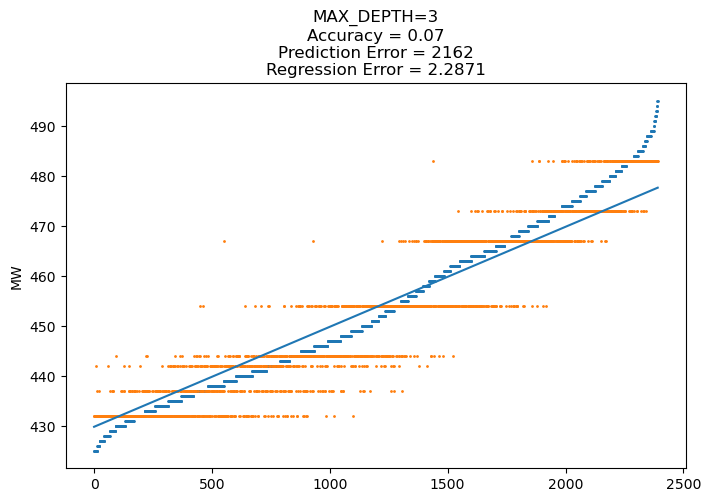

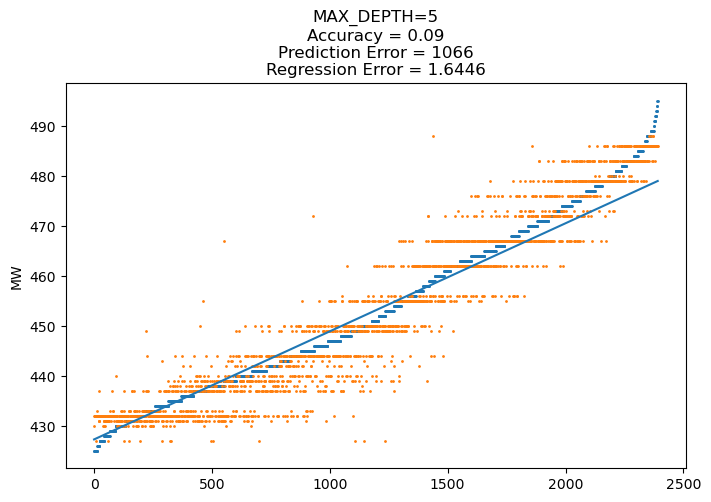

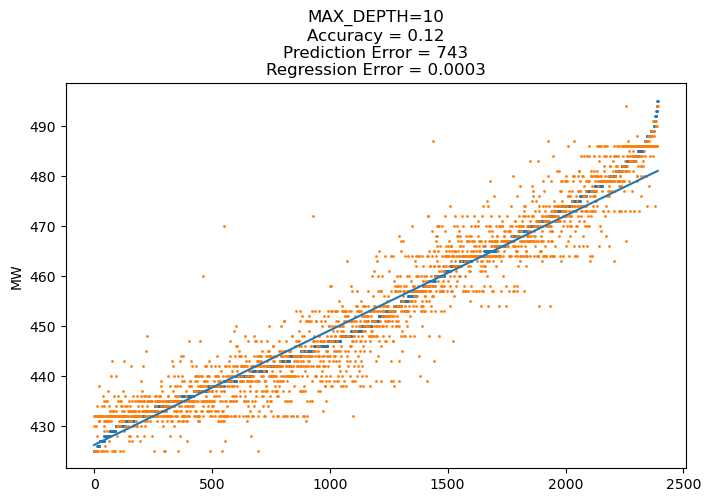

In [18]:
m_vals = np.linspace(0.02, 0.03, 100)
b_vals = np.linspace(420, 430, 100)

err = defaultdict(list)

for key, value in dt_pred.items():
    for m in m_vals:
        for b in b_vals:
            l1 = linear_function(m, x, b)
            mean_squared_error = (l1 - df['prediction']).sum()**2
            err[key].append((m, b, mean_squared_error))

    err_df = pd.DataFrame(err[key]).sort_values(2)    

    fig = plt.figure(figsize=(8,5))

    plt.ylabel('MW')

    df = pd.DataFrame(y_test)
    
    df['prediction'] = value

    pred_mse = (df['PE'] - df['prediction']).sum()

    plt.title(f"MAX_DEPTH={key}\nAccuracy = {np.round(metrics.accuracy_score(y_test, value),2)}\nPrediction Error = {pred_mse}\nRegression Error = {np.round(err_df.iloc[0,2],4)}")
    
    df = df.sort_values('PE').reset_index(drop=True)
    
    plt.scatter(df.index, df['PE'], s=1)
    
    plt.scatter(df.index, df['prediction'], s=1)

    plt.plot(x, linear_function(err_df.iloc[0,0], x, err_df.iloc[0,1]))

    plt.show()

<h3>Overfitting Analysis</h3>

None of the models show overfitting. Given the linear relationship, overfitting is not much of a concern with this dataset.

<h3>Tree Structure Comparison</h3>

As tree depth is raised, the interpretability of the decision tree visualization is lowered. Due to the simplicity of the dataset, quick visual analysis is effective in exploring the dataset. The lowered interpretability of the decision tree visualization detracts from the ability to perform quick visual analysis.

<h3>Technical Recommendation</h3>

The deepest tree was selected, due the improved accuracy. Both the accuracy of the decision tree, which is low to begin with, and the accuracy of the linear regression applied to the predictions, which has a low error, improve as the tree depth is raised. The bias-variance tradeoff does not seem like much of a concern, however, it also improves as the tree depth is raised. The models with the higher depth respond better to minute changes in the independent variables.

<h2>Section 3: Non-Technical Stakeholder Report</h2>

<h3>Business Question</h3>

When the plant is operating at 100% power, how much electricity do we output? The answer to this question can potentially lead us to lowering costs based on tempature, pressure, and similar variables.

<h3>Key Findings</h3>

The top three factors in predicting electrical output are:<br><br>

<img src="Figure18.png" width="500" height="500"/>

1. Relative Humidity (RH)<br>
2. Vacuum (V)<br>
3. Temperature(T)<br>

The simple model returned temperature (T) as the most important feature, whereas the complex model returns Relative Humidity (RH) as the most important feature. This leads me to believe that the tempeturate readings are dry bulb temperature readings, which are less accurate in measuring the effect of evaporative cooling. As the complexity of the model is raised, the minute changes in Relative Humidity are able to affect more accurate measurements.

<h3>Performance Summary</h3>

Our analysis predicts Electrical Output (PE) with an accuracy of approximately 99.7%.<br><br>


<center>
    <figure class="left-figure">
        <img src="Figure19.png" alt="Figure 19. Linear Regression" width="500" height="500">
        <figcaption><i>Figure 19. Linear Regression.</i></figcaption>
    </figure>
</center>

<h3>Real-World Example</h3>

What this means is that if the plant is operating at 100% power, then given the input variables, we can predict what the actual Electrical Output (PE) will be.<br>

1. Prediction := 460 MW ===> Actual PE will be somewhere in between 458.62 MW and 461.38 MW.<br>
2. Prediction := 430 MW ===> Actual PE will be somewhere in between 428.71 MW and 431.29 MW.<br>

<h3>Business Recommendations</h3>

1. The first and most important recommendation based on my findings is to use wet bulb temperature rather than dry bulb temperature in Electrical Output (PE) calculations. If these PE calculations are able to reduce costs, then having the most accurate measurements is preferred.
2. The second recommendation is to operate the plant such that Exhaust Vacuum (V) is maximized (cc HG lower). Ambient conditions are not alterable; however, certain plant parameters such as volumetric flow rate of coolant can be controlled such that Exhaust Vacuum is maximized.
3. Further exploration of the dataset is recommended. A quick analysis was utilized to come up with the predictive models. Further exploration and study would allow the development of more accurate and complex models.

<h3>Limitations</h3>

At the high range of the Electrical Output (PE) measurements, the accuracy is less than in the middle of the range. Additional complexity might be required to fully model PE at this power level.

<h2>Section 4: Reflection</h2>

The challenge in translating a technical report for a non-technical audience was mainly in veracity and accurate of the results of the technical report. The regression error results are accurate for what they are; however, in explaining the results to a non-technical audience, I had to reevaluate the results for accuracy. They don't make sense to communicate to a non-technical audience. For example, the decision trees return an accuracy of around 7 to 12%, depending on depth. This is an immediately low value, and if that score was used, then it would not communicate the findings of the report. Adding a linear regression to the decision tree results improve the accuracy to about 99.7%.

The other interesting part about the assignment was the difference between Temperature (T) and Relative Humidity (RH) in the max_depth=3 and max_depth=10 models. Based on my knowledge of power plant heat cycles, I would expect RH to be important. It was surprising that RH was not an import feature at all in the max_depth=3 model. My estimation is that dry bulb temperature was used and that as the model becomes more complex, the minute differences in RH are able to affect the model outcome, and thus improve accuracy. 

<h2>Section 3.a: Relevant Figures and Code</h2>

This section is just for some relevant figures and code that wouldn't be appropriate to include in the actual reports; however, would be appropriate to include at the end.

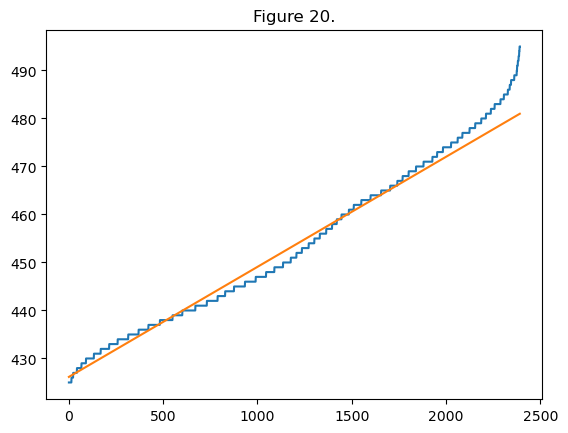

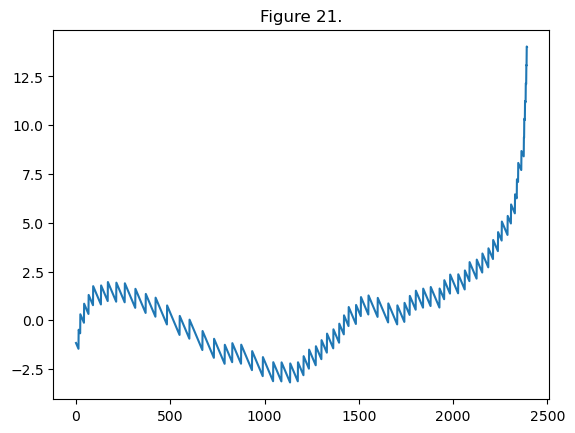

In [19]:

plt.plot(y_test.sort_values().reset_index(drop=True))
plt.plot(linear_function(err_df.iloc[0,0], np.linspace(0,y_test.shape[0]-1,y_test.shape[0]), err_df.iloc[0,1]))
plt.title(f"Figure 20.")
plt.show()
plt.plot(y_test.sort_values().reset_index(drop=True) - linear_function(err_df.iloc[0,0], np.linspace(0,y_test.shape[0]-1,y_test.shape[0]), err_df.iloc[0,1]))
plt.title(f"Figure 21.")
plt.show()

In [20]:
y_test.shape

(2392,)

In [21]:
linear_function(err_df.iloc[0,0], np.linspace(0,y_test.shape[0]-1,y_test.shape[0]), err_df.iloc[0,1]).shape

(2392,)

In [22]:
err_agg = (y_test.sort_values().reset_index(drop=True) - linear_function(err_df.iloc[0,0], np.linspace(0,y_test.shape[0]-1,y_test.shape[0]), err_df.iloc[0,1]))/y_test.sort_values().reset_index(drop=True)

In [23]:
err_agg.shape

(2392,)

In [24]:
err_agg[err_agg>=0].mean()

0.0038660266081592255

In [25]:
err_agg[err_agg<0].mean()

-0.0034887626075645944

In [26]:
460*0.997

458.62

In [27]:
460*1.003

461.37999999999994

In [28]:
430*0.997

428.71

In [29]:
430*1.003

431.28999999999996